### DATA

In [23]:
from JC_functions import *

In [24]:

def Triangle():
    return regular_gon(3)

def Square():
    return regular_gon(4)

def Pentagon():
    return regular_gon(5)

def Hexagon():
    return regular_gon(6)

def Heptagon():
    return regular_gon(7)

def Octagon():
    return regular_gon(8)

def Nonagon():
    return regular_gon(9)

def Circle(n=64):
    """Approximate a circle with n vertices"""
    return regular_gon(n)

def Star(n=5, spike=-0.5):
    """Regular star polygon"""
    return Spike(regular_gon(n), parameter=spike)

def RandomTransform(polygon,
                    scale_range=(0.5, 2.0),
                    shift_range=(-4, 4)):
    # random rotation
    angle = random.uniform(0, 2*math.pi)
    P = Rotate(angle, polygon)

    # random scaling (uniform)
    s = random.uniform(*scale_range)
    P = tuple(s * z for z in P)

    # random translation
    tx = random.uniform(*shift_range)
    ty = random.uniform(*shift_range)
    shift = complex(tx, ty)
    P = tuple(z + shift for z in P)

    return P

SHAPES = [
    ("Triangle", Triangle),
    ("Square", Square),
    ("Pentagon", Pentagon),
    ("Hexagon", Hexagon),
    ("Heptagon", Heptagon),
    ("Octagon", Octagon),
    ("Nonagon", Nonagon),
    ("Circle", Circle),
    ("Star", Star),
]

def GenerateDataset(samples_per_class=100):
    dataset = []

    for label, (name, shape_fn) in enumerate(SHAPES):
        for _ in range(samples_per_class):
            base = shape_fn()
            poly = RandomTransform(base)
            poly = Normalize(poly)  # optional but recommended
            dataset.append({
                "polygon": poly,
                "label": label,
                "name": name
            })

    return dataset

def GenerateFeatureDataset(samples_per_class=100):
    X = []
    y = []

    for label, (name, shape_fn) in enumerate(SHAPES):
        for _ in range(samples_per_class):
            poly = RandomTransform(shape_fn())
            poly = Normalize(poly)
            X.append(features(poly))
            y.append(label)

    return np.array(X), np.array(y)


In [25]:
def edge_lengths(polygon):
    n = len(polygon)
    return [abs(polygon[(k+1)%n] - polygon[k]) for k in range(n)]

def total_length(polygon):
    return sum(edge_lengths(polygon))

def ResampleArcLength(polygon, N=500):
    n = len(polygon)
    lengths = edge_lengths(polygon)
    L = sum(lengths)

    # cumulative arc-length
    cum = [0]
    for l in lengths:
        cum.append(cum[-1] + l)

    new_points = []
    step = L / N
    target = 0
    edge = 0

    for _ in range(N):
        while target > cum[edge+1]:
            edge += 1

        z0 = polygon[edge]
        z1 = polygon[(edge+1)%n]
        t = (target - cum[edge]) / lengths[edge]
        new_points.append((1-t)*z0 + t*z1)

        target += step

    return tuple(new_points)

def Shape500(shape_fn, N=500):
    base = shape_fn()
    smooth = ResampleArcLength(base, N)
    return Normalize(smooth)

def RandomShape500(shape_fn, N=500):
    poly = Shape500(shape_fn, N)
    poly = Rotate(random.uniform(0,2*math.pi), poly)

    s = random.uniform(0.7, 1.8)
    poly = tuple(s*z for z in poly)

    shift = complex(random.uniform(-4,4), random.uniform(-4,4))
    poly = tuple(z + shift for z in poly)

    return poly

SHAPES = [
    ("Triangle", Triangle),
    ("Square", Square),
    ("Pentagon", Pentagon),
    ("Hexagon", Hexagon),
    ("Heptagon", Heptagon),
    ("Octagon", Octagon),
    ("Nonagon", Nonagon),
    ("Circle", Circle),
    ("Star", Star),
]



In [26]:
def is_ccw(polygon):
    """Returns True if polygon is counter-clockwise oriented."""
    return area(polygon) > 0

def OrientCCW(polygon):
    """
    Ensures polygon is counter-clockwise oriented.
    If polygon is clockwise, it is reversed.
    """
    if area(polygon) < 0:
        return tuple(reversed(polygon))
    return polygon

def CenterMass(X):
    """
    Center of mass of a polygon.
    Polygon is automatically oriented counter-clockwise.
    """
    X = OrientCCW(X)
    return CyclicSum(pre_cm, X) / (area(X) * (0 + 2j))

def Normalize(X):
    """
    Displaces polygon so its center of mass is at the origin
    and scales it so its area equals 10.
    Orientation is fixed automatically.
    """
    X = OrientCCW(X)
    CM = CenterMass(X)
    a = math.sqrt(area(X) / 10)
    return tuple((z - CM) / a for z in X)

def CenterPolygon(X):
    """Centers polygon so that its center of mass is at the origin."""
    X = OrientCCW(X)
    CM = CenterMass(X)
    return tuple(z - CM for z in X)

def GenerateShapeArray(
        samples_per_class=100,
        points_per_shape=500,
        perturbation_strength=0.02):

    polygons = []
    labels = []

    for label, (name, shape_fn) in enumerate(SHAPES):
        for _ in range(samples_per_class):

            poly = ResampleArcLength(shape_fn(), points_per_shape)
            poly = Rotate(random.uniform(0, 2 * math.pi), poly)

            scale = random.uniform(0.7, 1.8)
            poly = tuple(scale * z for z in poly)

            # Perturbation:
            poly = tuple(
                z + complex(
                    random.uniform(-perturbation_strength, perturbation_strength),
                    random.uniform(-perturbation_strength, perturbation_strength)
                )
                for z in poly
            )

            poly = ResampleArcLength(poly, points_per_shape)
            poly = OrientCCW(poly)

            #I NORMALIZE AGAIN JUST FOR SAFETY
            poly = Normalize(poly)

            polygons.append(poly)
            labels.append(label)

    return np.array(polygons, dtype=object), np.array(labels)


In [27]:
polygons, labels = GenerateShapeArray()
data = GenerateFeatureDataset(10)

In [28]:
def is_finite(z):
    if isinstance(z, complex):
        return np.isfinite(z.real) and np.isfinite(z.imag)
    return np.isfinite(z)

def max_diff(a, b):
    if isinstance(a, complex):
        return abs(a - b)
    return abs(a - b)

def test_moment_finiteness(polygon, max_order=3):
    for p in range(max_order + 1):
        for q in range(max_order + 1):
            for r in range(max_order + 1):
                try:
                    m = Moment(p, q, r, polygon)
                    if not is_finite(m):
                        print("FAIL (non-finite):", p, q, r)
                        return False
                except Exception as e:
                    print("EXCEPTION:", p, q, r, e)
                    return False
    return True

def test_translation_invariance(polygon):
    P = Normalize(polygon)
    shift = complex(3.2, -1.7)
    Q = tuple(z + shift for z in P)

    for p,q,r in [(0,0,0), (1,0,0), (1,1,0), (1,2,1)]:
        if max_diff(Moment(p,q,r,P), Moment(p,q,r,Q)) > 1e-6:
            print("FAIL translation:", p,q,r)
            print(max_diff(Moment(p,q,r,P), Moment(p,q,r,Q)))
            Draw(P)
            Draw(Q)
            return True#False
    return True

def test_rotation_invariance(polygon):
    P = Normalize(polygon)
    angle = random.uniform(0, 2*np.pi)
    Q = Rotate(angle, P)

    for p,q,r in [(1,0,0), (1,1,0), (1,2,1)]:
        m1 = Moment(p,q,r,P)
        m2 = Moment(p,q,r,Q)
        if abs(abs(m1) - abs(m2)) > 1e-6:
            print("FAIL rotation:", p,q,r)
            print(max_diff(Moment(p,q,r,P), Moment(p,q,r,Q)))
            return False
        else:
            print("PASS rotation:", p,q,r)
    return True

def test_scale_behavior(polygon):
    P = Normalize(polygon)
    s = random.uniform(0.5, 2.0)
    Q = tuple(s*z for z in P)

    for p,q,r in [(0,0,0), (1,0,0), (2,1,1)]:
        m1 = Moment(p,q,r,P)
        m2 = Moment(p,q,r,Q)

        expected = abs(s)**(p+q+r+1)
        ratio = abs(m2/m1) if abs(m1) > 1e-12 else 1

        if abs(ratio - expected) > 1e-4:
            print("FAIL scale:", p,q,r)
            print(max_diff(Moment(p,q,r,P), Moment(p,q,r,Q)))
            Draw(P)
            Draw(Q)
            return False
        else:
            print("PASS scale:", p,q,r)
    return True

def test_feature_invariance(polygon):
    P = Normalize(polygon)

    Q = Rotate(random.uniform(0,2*np.pi), P)
    Q = tuple(random.uniform(0.7,1.8)*z for z in Q)
    Q = tuple(z + complex(2,-1) for z in Q)
    Q = Normalize(Q)

    f1 = features(P)
    f2 = features(Q)

    for a,b in zip(f1,f2):
        if abs(a - b) > 1e-5:
            print("FAIL features: ", a, b)
            return False
        else:
            print("PASS features: ", a, b)

    g1 = features2(P)
    g2 = features2(Q)

    for a,b in zip(g1,g2):
        if abs(a - b) > 1e-5:
            print("FAIL features2,: ", a, b)
            return False
        else:
            print("PASS features2: ", a, b)

    if abs(affine(P) - affine(Q)) > 1e-5:
        print("FAIL affine: ", affine(P), affine(Q))
        return False
    else:
        print("PASS affine: ", affine(P), affine(Q))

    return True
def run_all_moment_tests(polygons, n_tests=2):
    tests = [
        test_moment_finiteness,
        #test_translation_invariance,
        test_rotation_invariance,
        test_scale_behavior,
        test_feature_invariance
    ]

    for i in range(n_tests):
        for P in polygons:
            for test in tests:
                if not test(P):
                    print("FAILED:", test.__name__)
                else:
                    print("PASSED:", test.__name__)
    print("ALL MOMENT TESTS PASSED ✔")


In [29]:
polygons, labels = GenerateShapeArray(
        samples_per_class=3,
        points_per_shape=500)


In [30]:
from JC_momenst import *
test = Features(polygons[0])
print("Number of invariants:", len(test))

Number of invariants: 80


In [31]:
import numpy as np
import matplotlib.pyplot as plt

def plot_invariant_pair(X, labels, i, j, title=None, s=20):
    """
    Plot all shapes in the 2D space defined by invariants (i, j),
    colored by class labels.

    Parameters
    ----------
    X : ndarray, shape (N, D)
        Invariant feature matrix (real-valued).
    labels : ndarray, shape (N,)
        Class labels.
    i, j : int
        Indices of the two invariants to plot.
    title : str or None
        Optional plot title.
    s : int
        Marker size.
    """

    if i == j:
        raise ValueError("Invariant indices i and j must be different.")

    if i < 0 or j < 0 or i >= X.shape[1] or j >= X.shape[1]:
        raise IndexError("Invariant index out of range.")

    plt.figure(figsize=(6, 5))

    classes = np.unique(labels)
    for c in classes:
        idx = labels == c
        plt.scatter(
            X[idx, i],
            X[idx, j],
            s=s,
            alpha=0.7,
            label=f"Class {c}"
        )

    plt.xlabel(f"Invariant {i}")
    plt.ylabel(f"Invariant {j}")

    if title is None:
        plt.title(f"Invariant space: ({i}, {j})")
    else:
        plt.title(title)

    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


C:\Users\LONGA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\LONGA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_mds.py:744: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9. To suppress this warning, provide some value of `n_init`.
  warnings.warn(
C:\Users\LONGA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_mds.py:754: FutureWarning: The default value of `init` will change from 'random' to 'classical_mds' in 1.10. To suppress this warning, provide some value of `init`.
  warnings.warn(


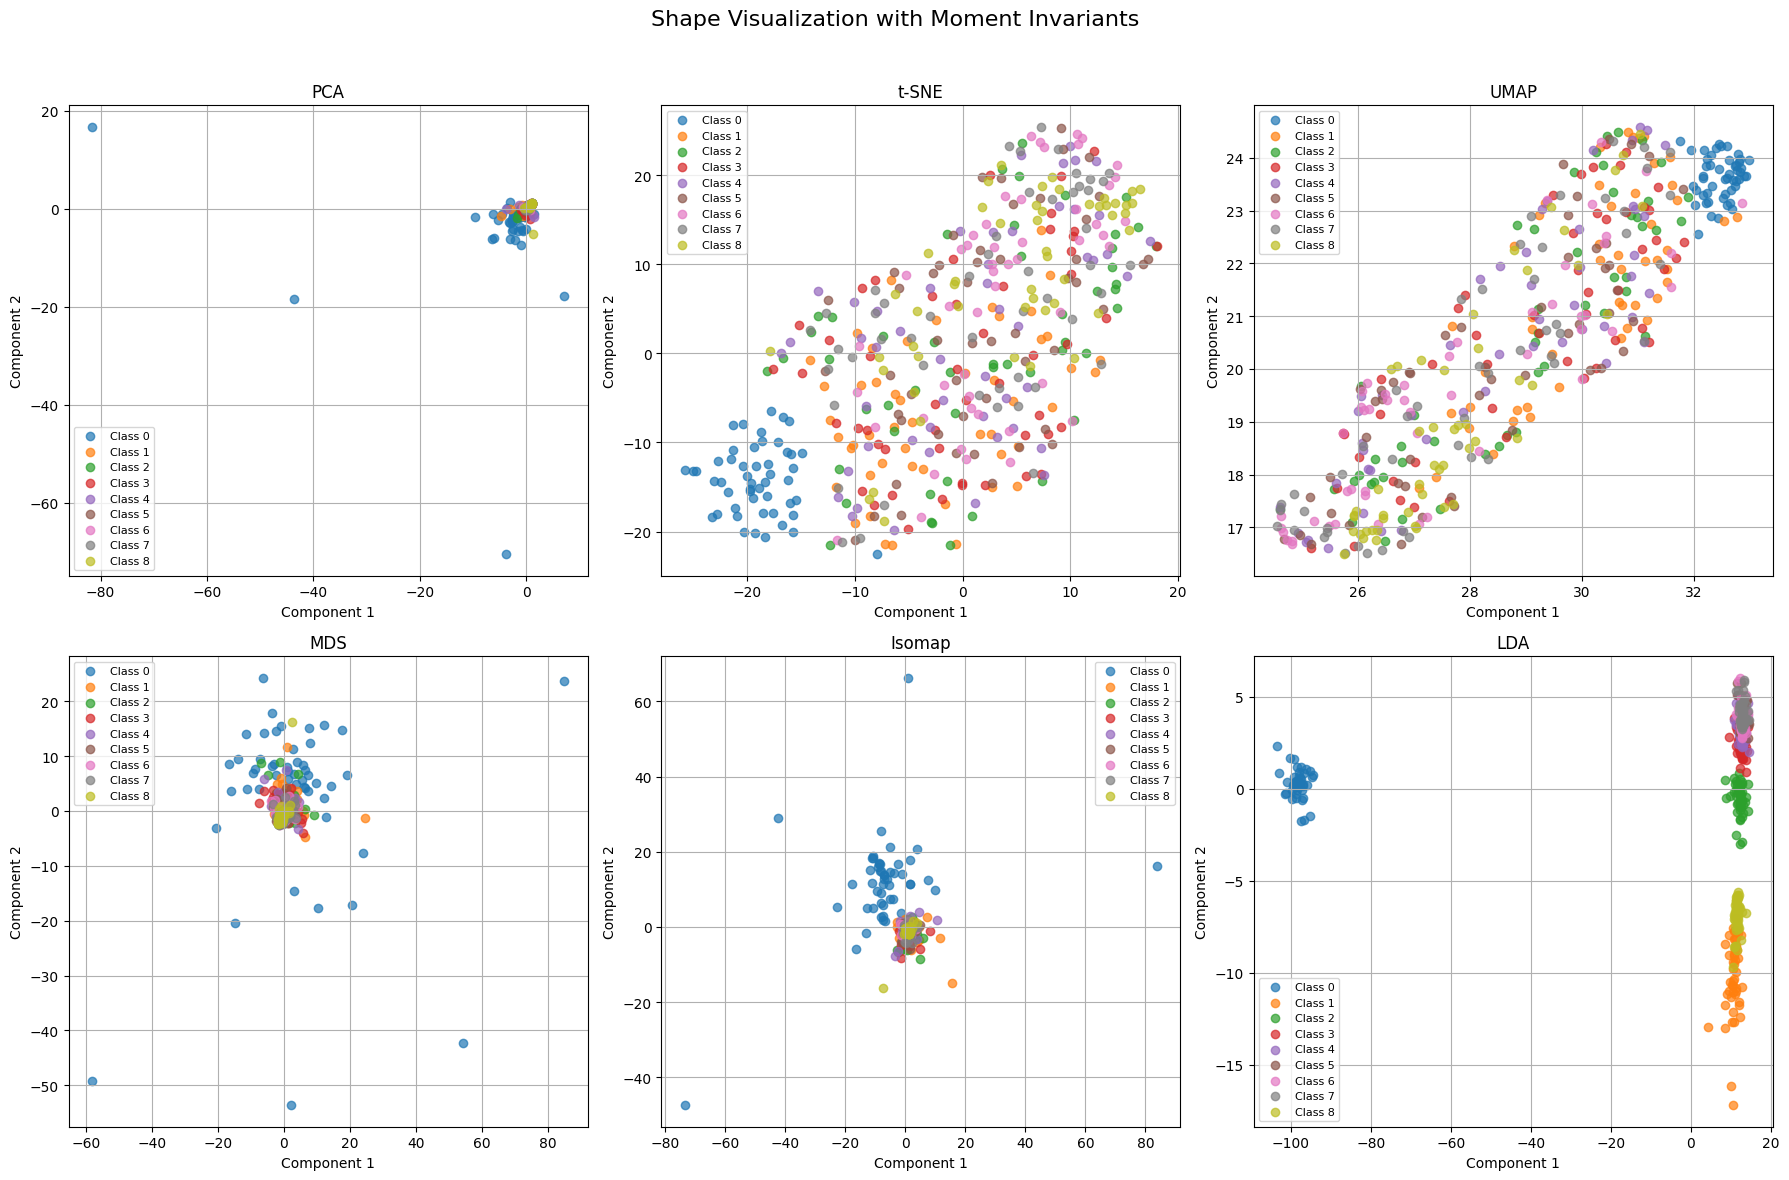

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from umap import UMAP


polygons, labels = GenerateShapeArray(
    samples_per_class=50, points_per_shape=500, perturbation_strength=0.02
)

feature_dicts = [features_new(poly) for poly in polygons]

feature_names = list(feature_dicts[0].keys())
X = np.array([
    [fd[name].real if np.iscomplexobj(fd[name]) else fd[name] for name in feature_names]
    for fd in feature_dicts
], dtype=float)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

methods = {
    "PCA": PCA(n_components=2),
    "t-SNE": TSNE(n_components=2, random_state=42, perplexity=30),
    "UMAP": UMAP(n_components=2, random_state=42),
    "MDS": MDS(n_components=2, random_state=42),
    "Isomap": Isomap(n_components=2),
}

if len(set(labels)) > 1:
    methods["LDA"] = LDA(n_components=2)

plt.figure(figsize=(18, 12))

n_clusters = len(np.unique(labels))

for i, (name, model) in enumerate(methods.items(), 1):
    plt.subplot(2, 3, i)

    if name == "LDA":
        X_2d = model.fit_transform(X_scaled, labels)
    else:
        X_2d = model.fit_transform(X_scaled)

    for label_id in range(n_clusters):
        idx = labels == label_id
        plt.scatter(X_2d[idx, 0], X_2d[idx, 1], alpha=0.7, label=f"Class {label_id}")

    plt.title(name)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.legend(loc="best", fontsize=8)

plt.suptitle("Shape Visualization with Moment Invariants", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


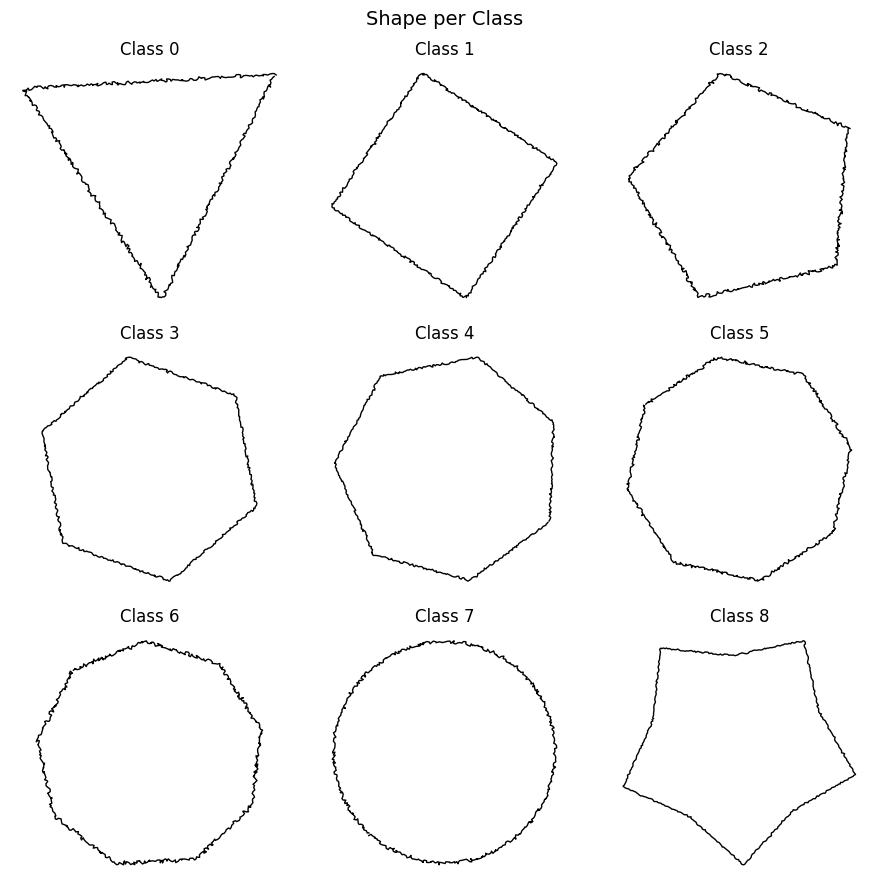

In [33]:
def one_polygon_per_class(polygons, labels):
    selected = {}
    for poly, lab in zip(polygons, labels):
        if lab not in selected:
            selected[lab] = poly
    return selected

import matplotlib.pyplot as plt

selected = one_polygon_per_class(polygons, labels)
n_classes = len(selected)

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.flatten()

for ax, (lab, poly) in zip(axes, sorted(selected.items())):
    xs = [z.real for z in poly]
    ys = [z.imag for z in poly]

    ax.plot(xs, ys, "-k", linewidth=1)
    ax.set_title(f"Class {lab}")
    ax.set_aspect("equal")
    ax.axis("off")

plt.suptitle("Shape per Class", fontsize=14)
plt.tight_layout()
plt.show()


In [34]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    X, labels,
    test_size=0.25,
    random_state=42,
    stratify=labels
)



rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)



y_pred = rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred))

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))


Test accuracy: 0.3097

Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       0.22      0.33      0.27        12
           2       0.25      0.08      0.12        13
           3       0.00      0.00      0.00        13
           4       0.11      0.08      0.09        13
           5       0.33      0.33      0.33        12
           6       0.19      0.23      0.21        13
           7       0.21      0.25      0.23        12
           8       0.44      0.54      0.48        13

    accuracy                           0.31       113
   macro avg       0.30      0.32      0.30       113
weighted avg       0.29      0.31      0.29       113


Confusion matrix:
[[12  0  0  0  0  0  0  0  0]
 [ 0  4  0  4  1  0  1  0  2]
 [ 1  2  1  2  0  1  1  2  3]
 [ 0  4  0  0  2  3  1  2  1]
 [ 0  5  1  1  1  1  2  1  1]
 [ 0  0  1  1  1  4  3  1  1]
 [ 0  0  0  0  2  3  3  4  1]
 [ 0  2  1  1  1  0 

In [35]:
def find_strongly_correlated_invariants(X, feature_names=None, threshold=0.9):
    """
    Find pairs of invariant features that are strongly correlated.

    Parameters
    ----------
    X : ndarray, shape (N, D)
        Real-valued invariant feature matrix
    feature_names : list of str, optional
        Names of the features. If None, indices will be used.
    threshold : float
        Absolute correlation above which a pair is considered strongly correlated.

    Returns
    -------
    correlated_pairs : list of tuples
        List of tuples (feature_i, feature_j, correlation_value)
    correlated_couples : list of tuples
        List of tuples (feature_i, feature_j) only
    """

    corr_matrix = np.corrcoef(X, rowvar=False)

    D = X.shape[1]
    correlated_pairs = []
    correlated_couples = []


    if feature_names is None:
        feature_names = [f"{i}" for i in range(D)]

    for i in range(D):
        for j in range(i + 1, D):
            if abs(corr_matrix[i, j]) >= threshold:
                correlated_pairs.append((feature_names[i], feature_names[j], corr_matrix[i, j]))
                correlated_couples.append((feature_names[i], feature_names[j]))

    return correlated_pairs, correlated_couples


In [36]:
feature_names = list(feature_dicts[0].keys())
pairs_with_corr, pairs_only = find_strongly_correlated_invariants(X, feature_names = feature_names, threshold=0.9)

print("Pairs with correlation values:")
for f1, f2, val in pairs_with_corr:
    print(f"{f1} ↔ {f2}: corr = {val:.3f}")

print("\nPairs only:")
print(pairs_only)


Pairs with correlation values:
feature_1 ↔ feature_6: corr = 0.968
feature_2 ↔ feature_12: corr = 0.915
feature_7 ↔ feature_40: corr = 0.948
feature_8 ↔ feature_34: corr = 0.905
feature_8 ↔ feature_39: corr = 0.974
feature_9 ↔ feature_16: corr = 0.955
feature_13 ↔ feature_18: corr = 0.951
feature_13 ↔ feature_45: corr = 0.921
feature_13 ↔ feature_47: corr = 0.955
feature_13 ↔ feature_51: corr = 0.983
feature_13 ↔ feature_53: corr = 0.962
feature_14 ↔ feature_35: corr = 0.948
feature_14 ↔ feature_46: corr = 0.966
feature_14 ↔ feature_52: corr = 0.983
feature_15 ↔ feature_16: corr = 0.962
feature_18 ↔ feature_47: corr = 0.957
feature_18 ↔ feature_53: corr = 0.993
feature_20 ↔ feature_21: corr = -0.921
feature_20 ↔ feature_23: corr = 0.994
feature_21 ↔ feature_23: corr = -0.933
feature_21 ↔ feature_60: corr = -0.910
feature_21 ↔ feature_62: corr = -0.904
feature_22 ↔ feature_38: corr = 0.902
feature_28 ↔ feature_39: corr = 0.963
feature_32 ↔ feature_60: corr = 0.925
feature_34 ↔ feature_3

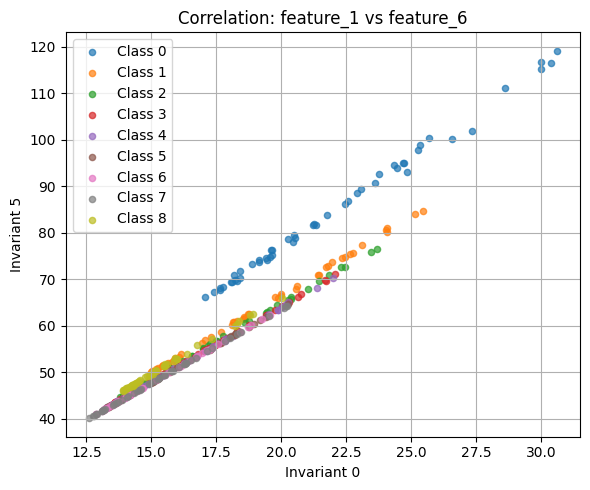

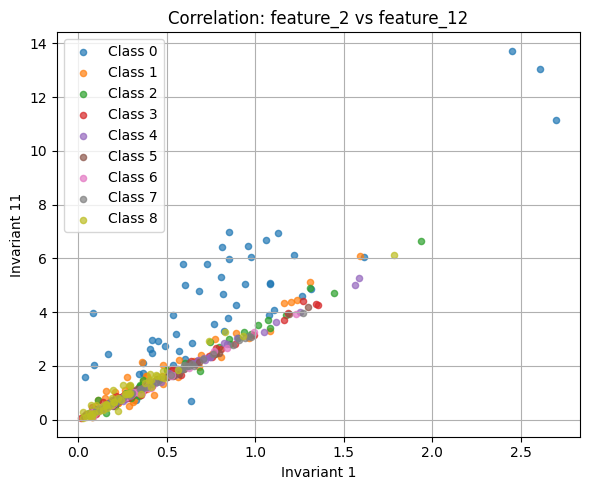

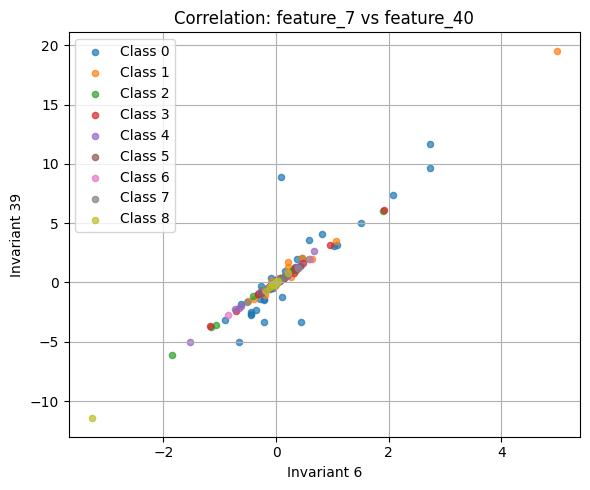

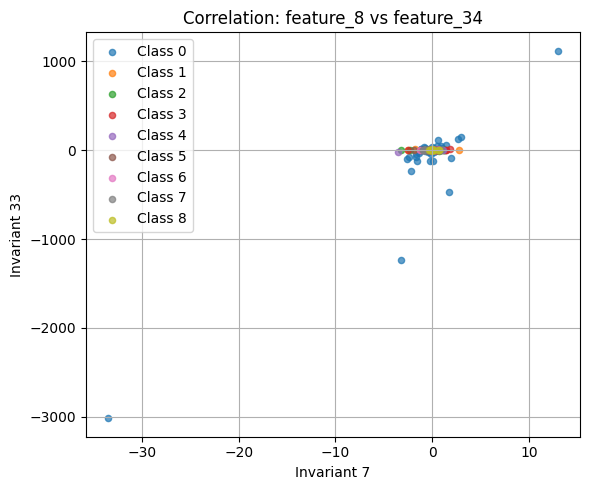

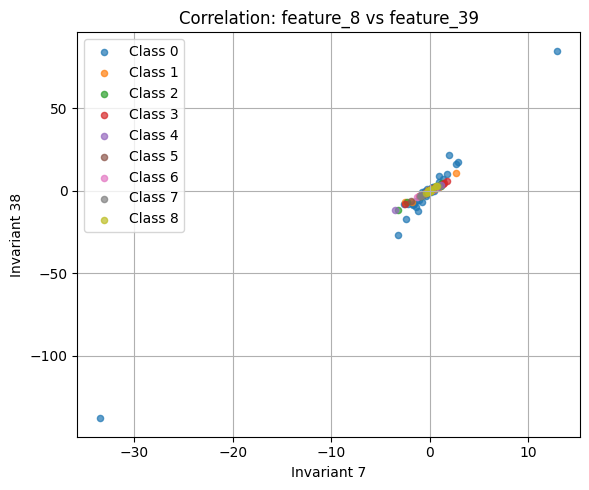

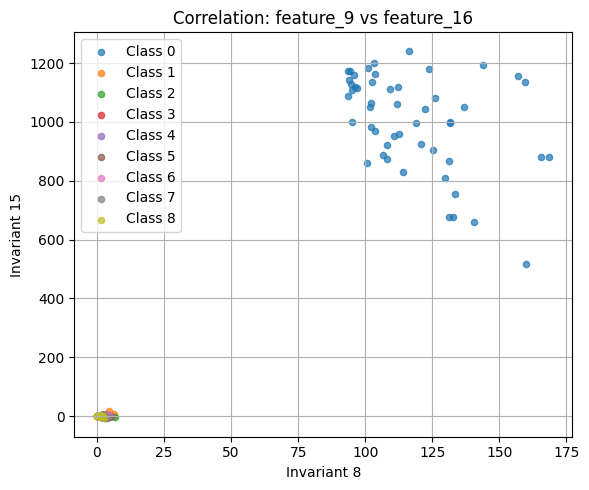

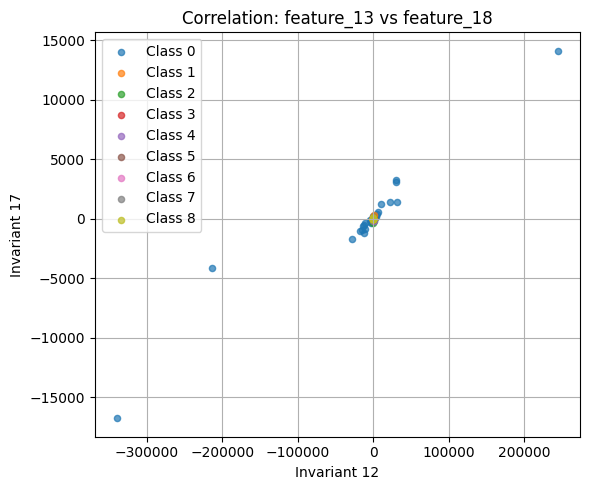

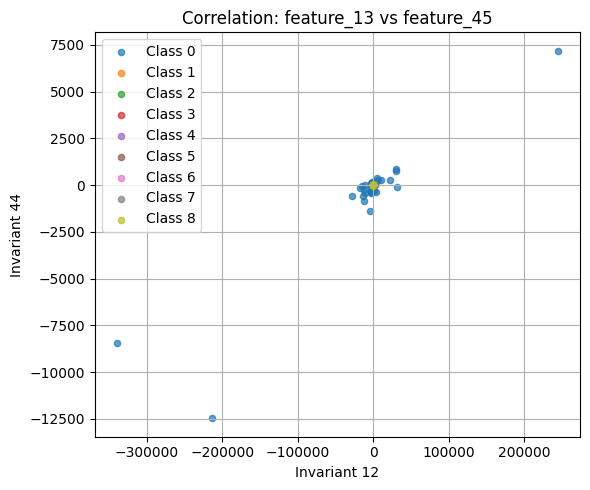

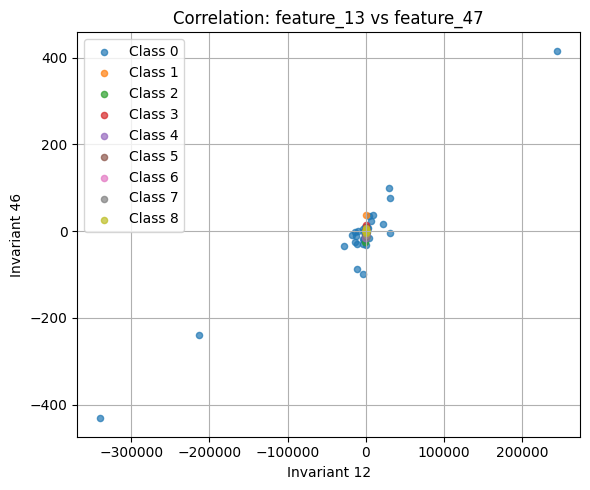

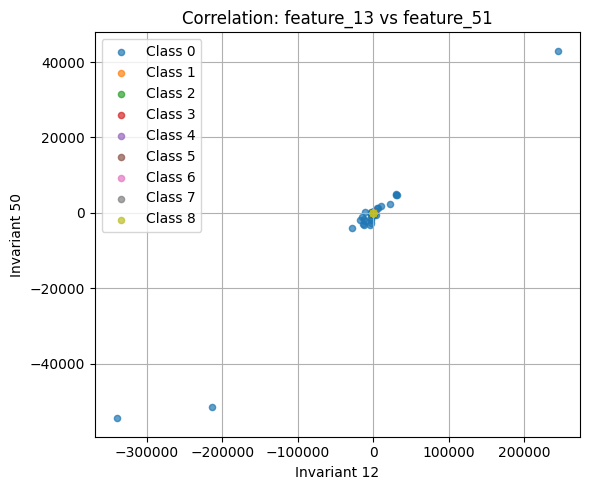

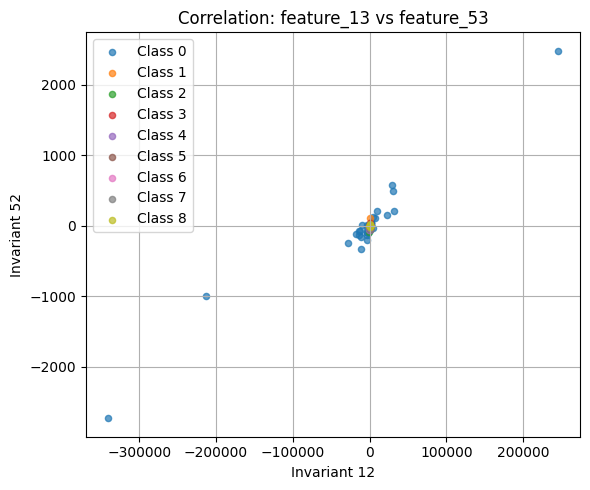

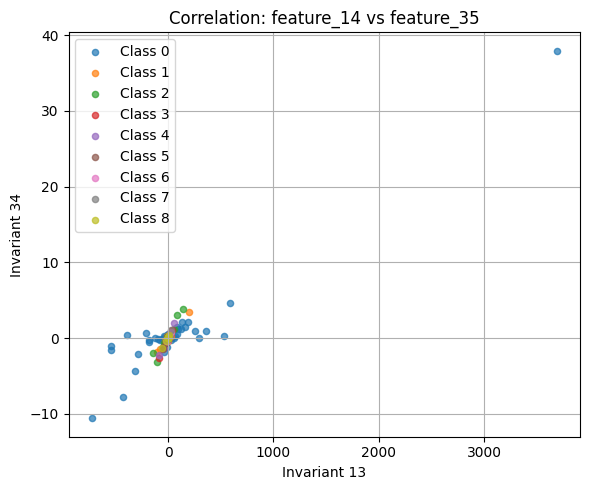

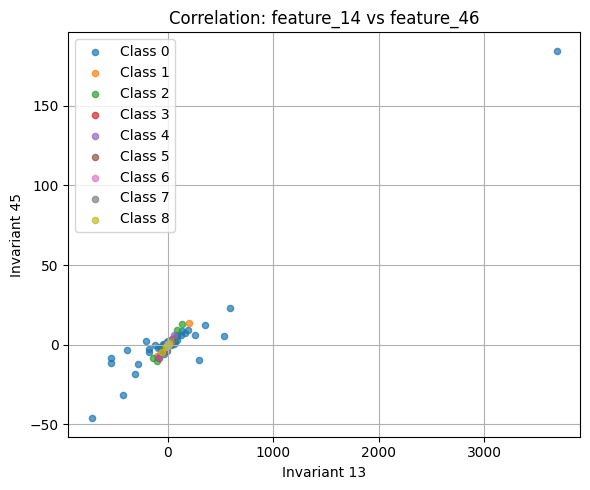

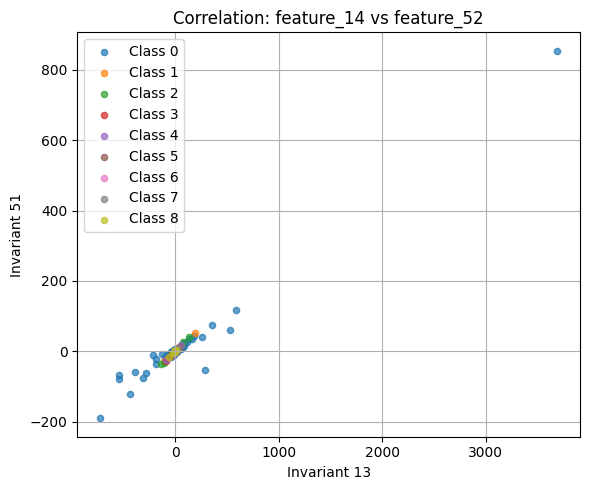

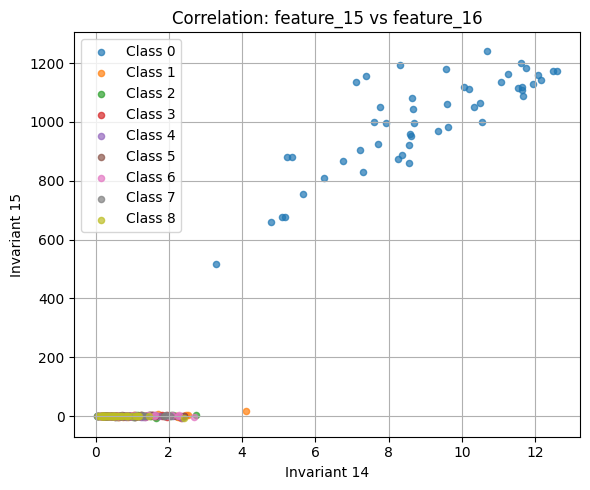

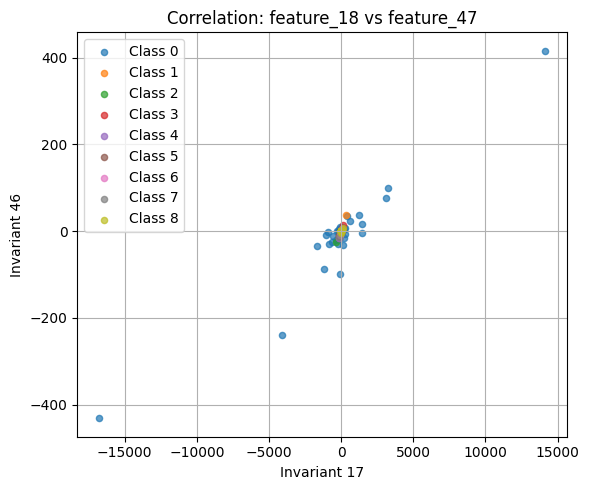

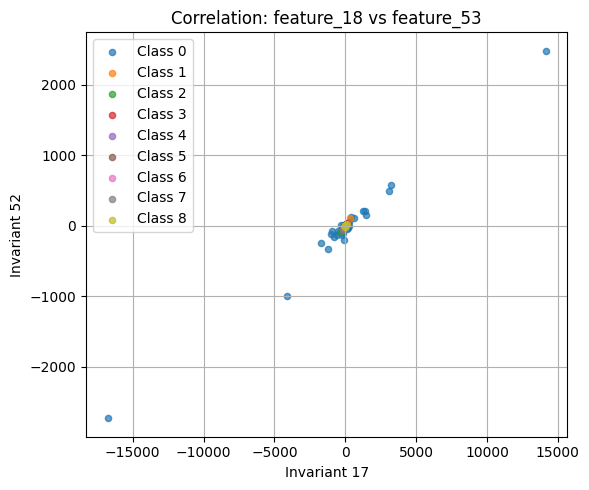

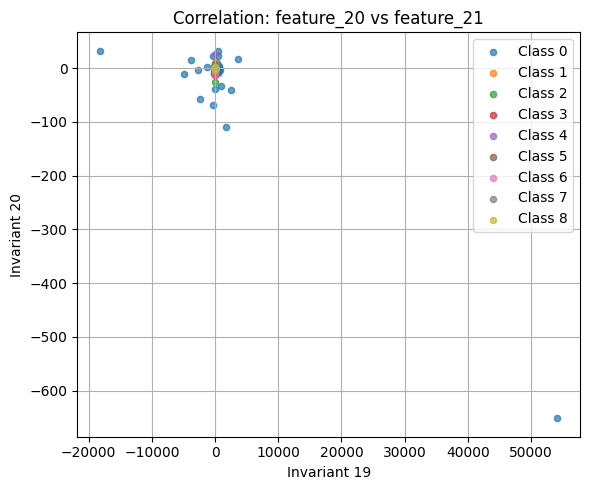

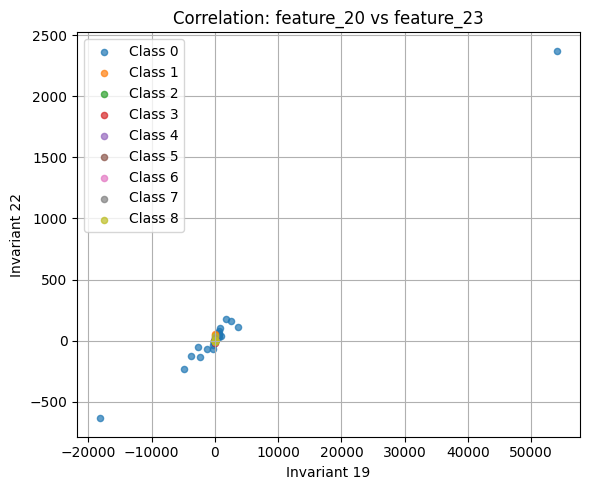

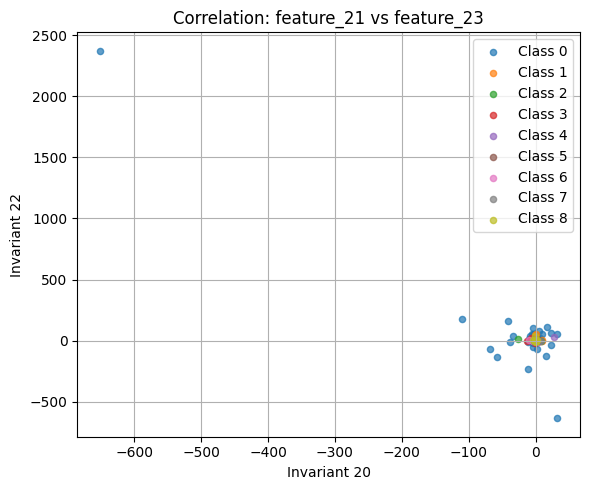

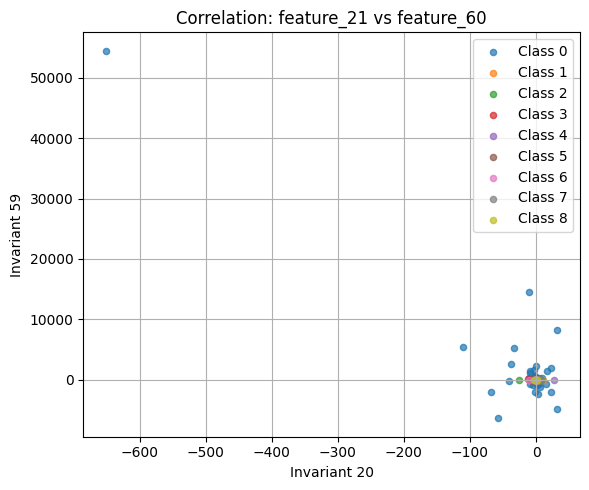

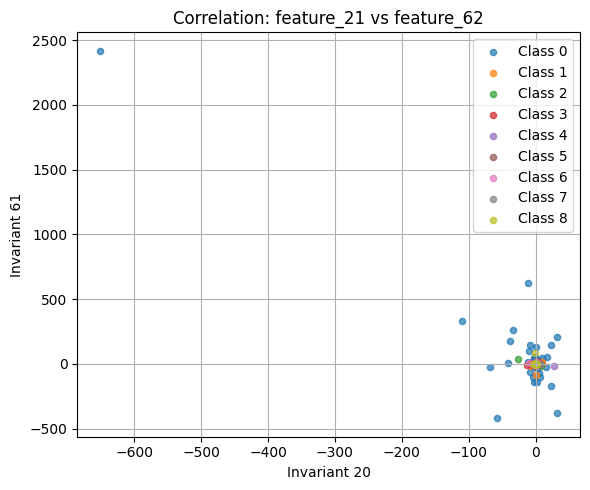

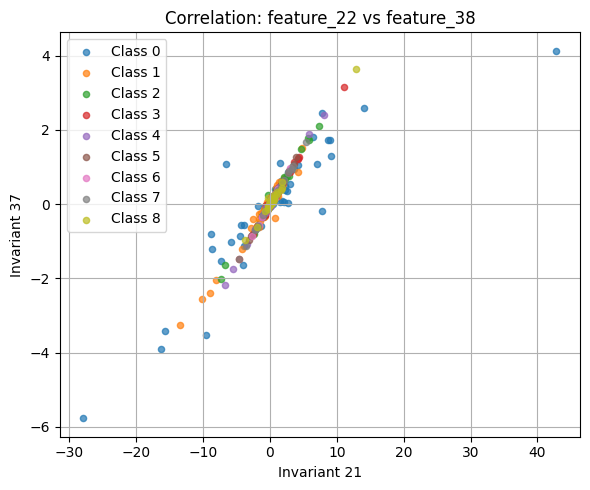

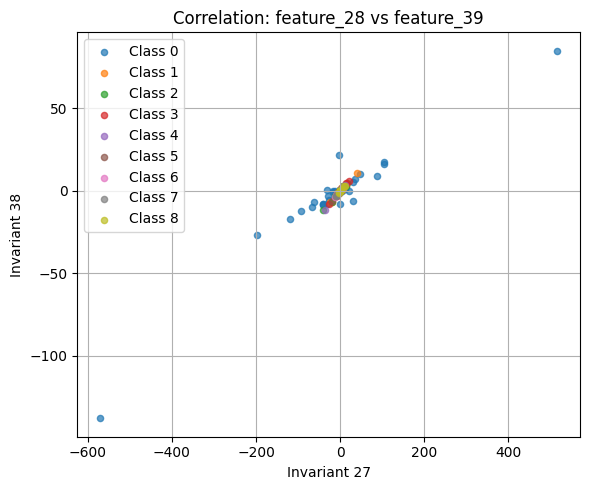

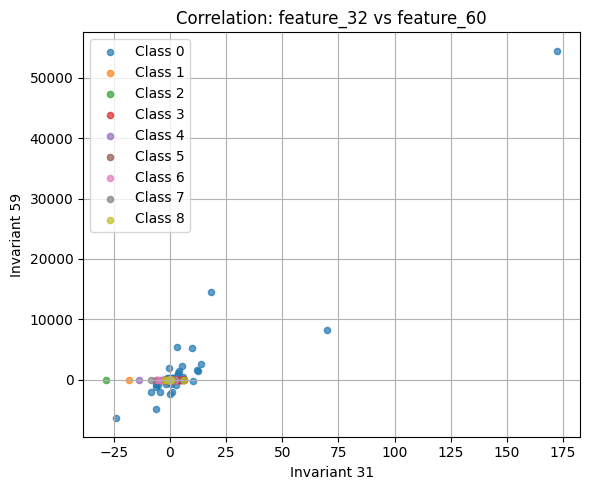

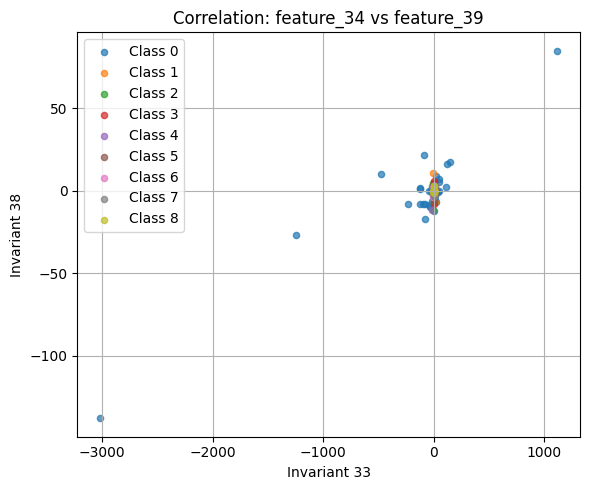

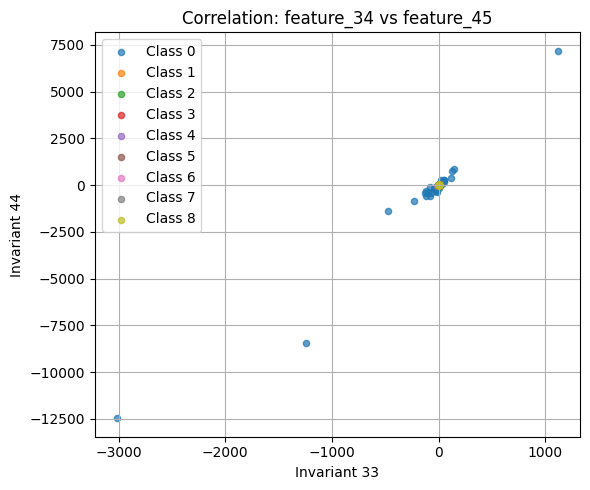

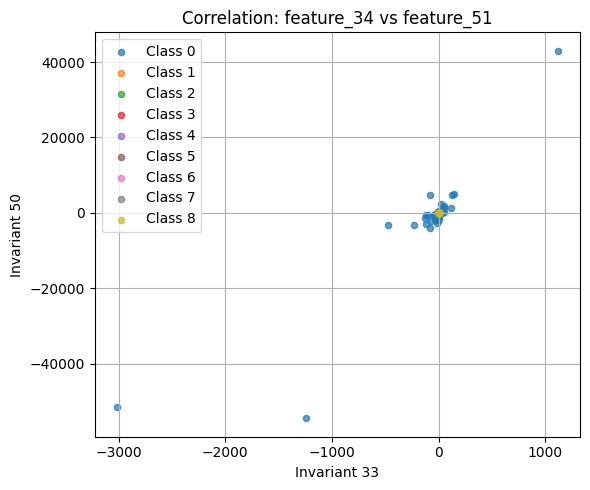

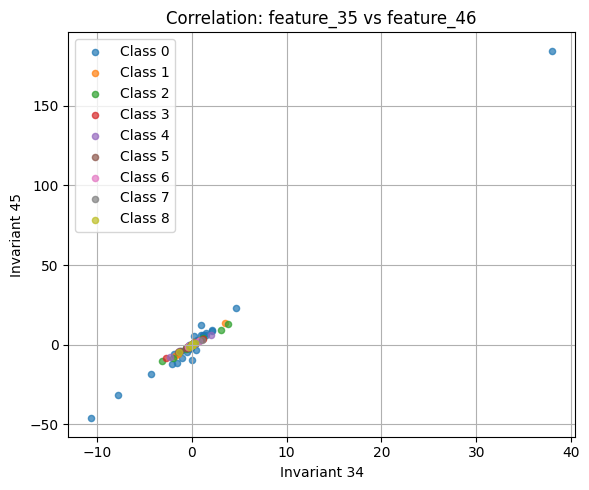

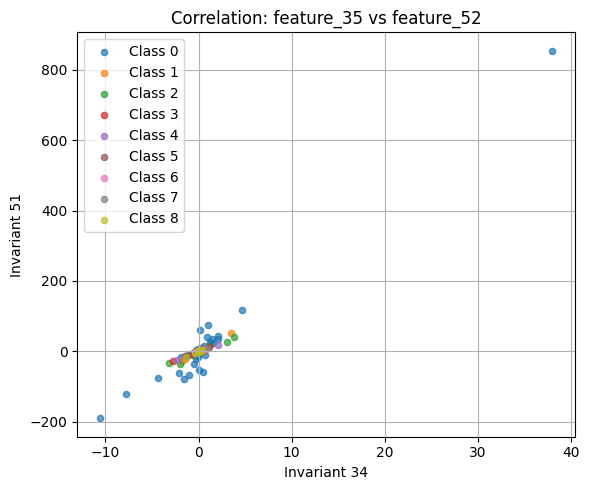

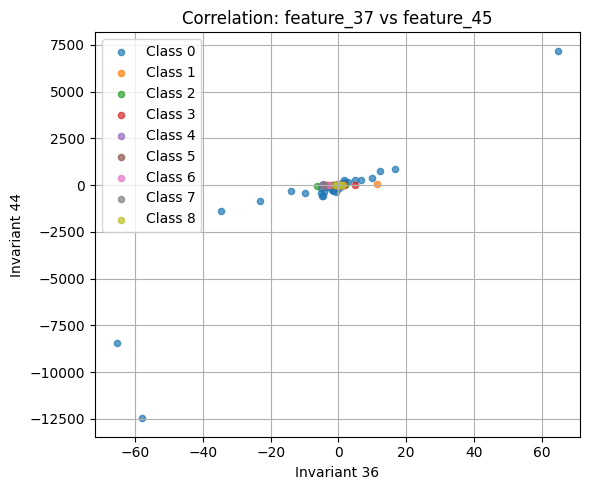

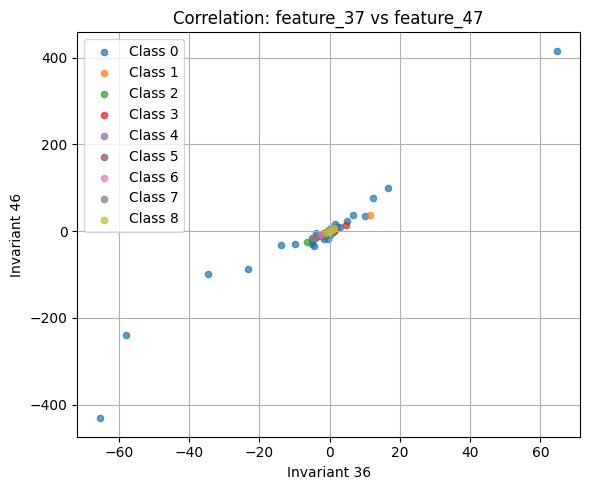

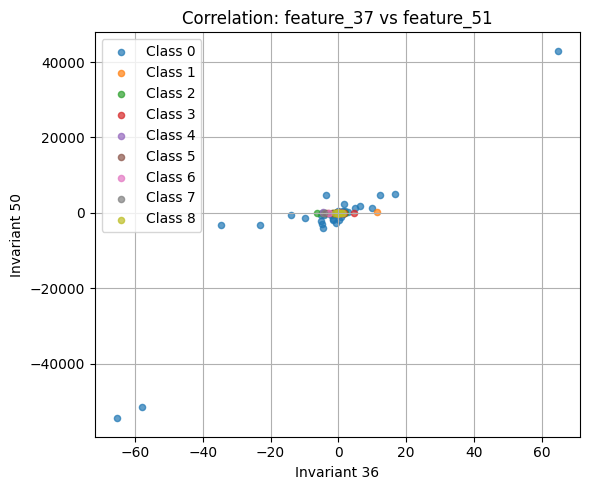

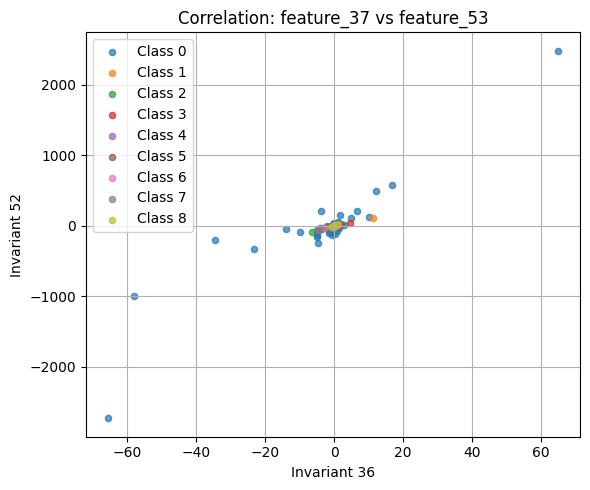

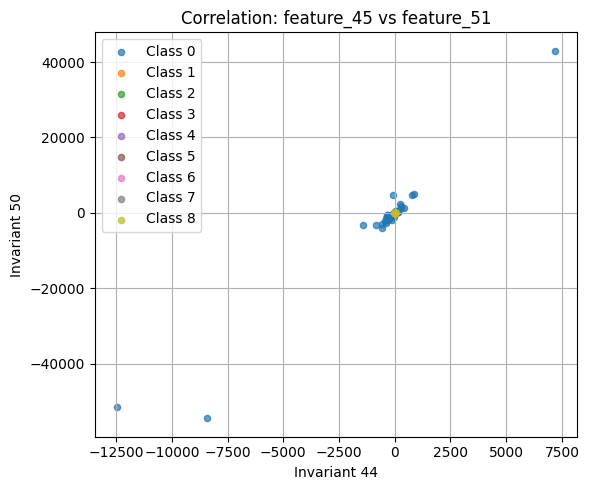

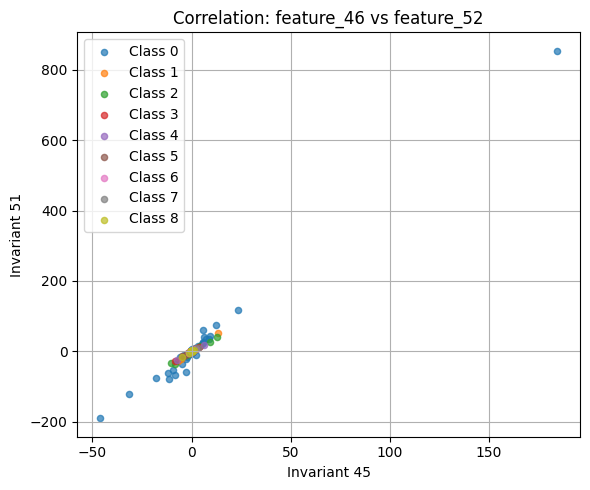

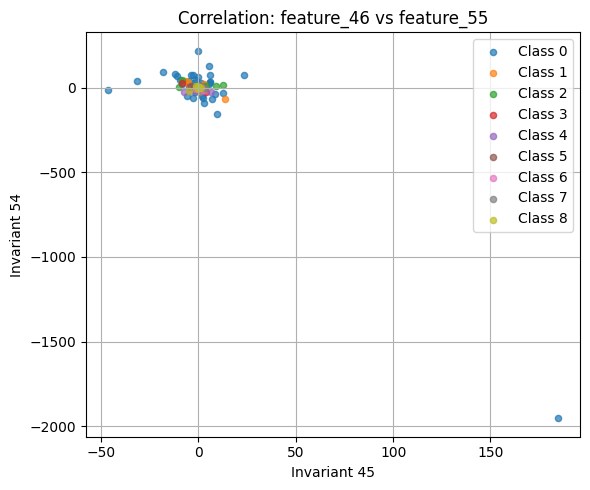

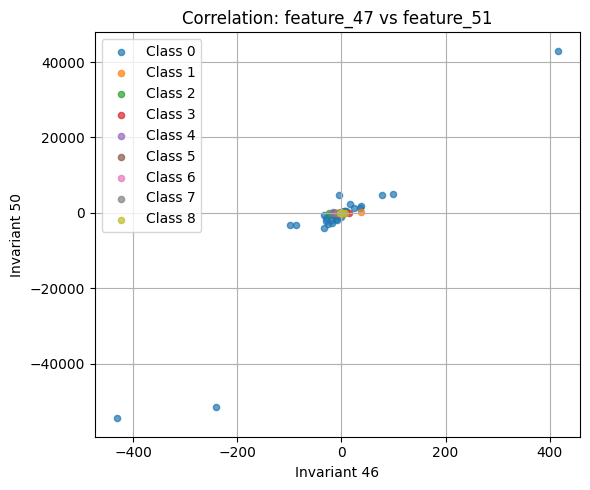

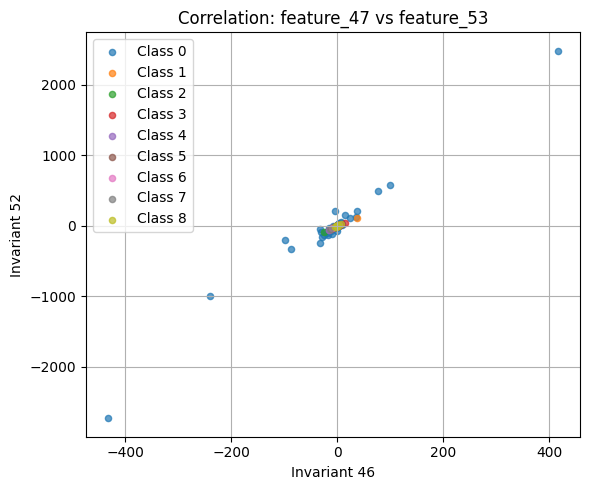

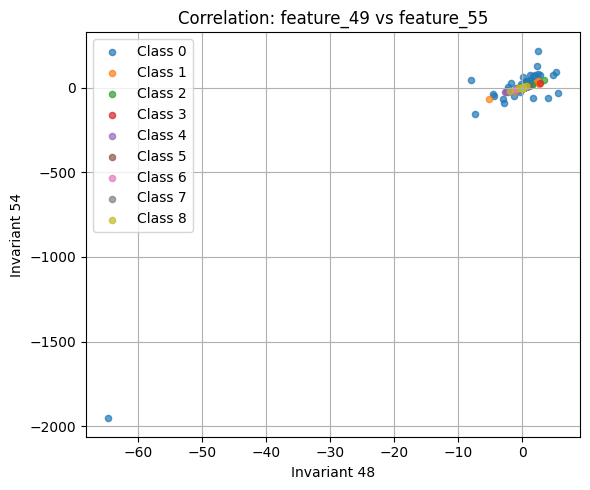

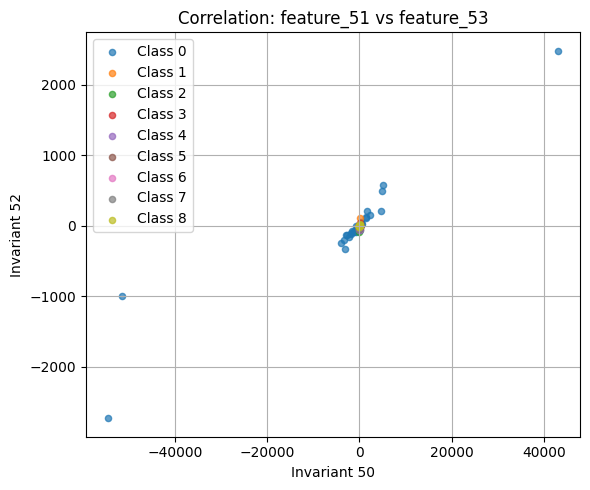

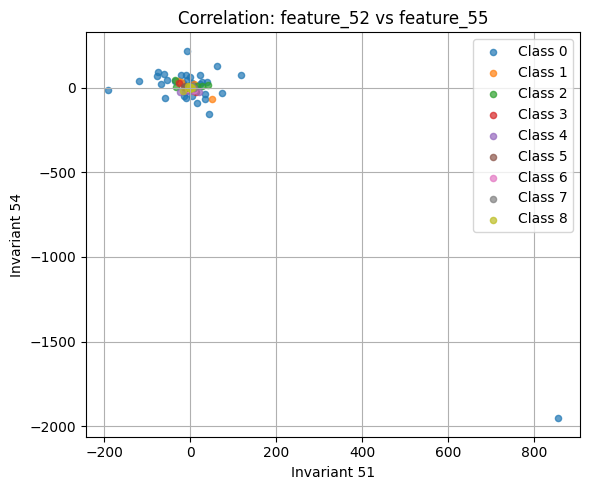

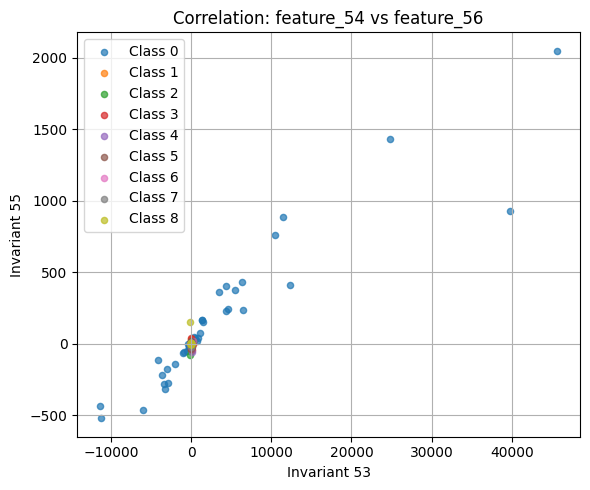

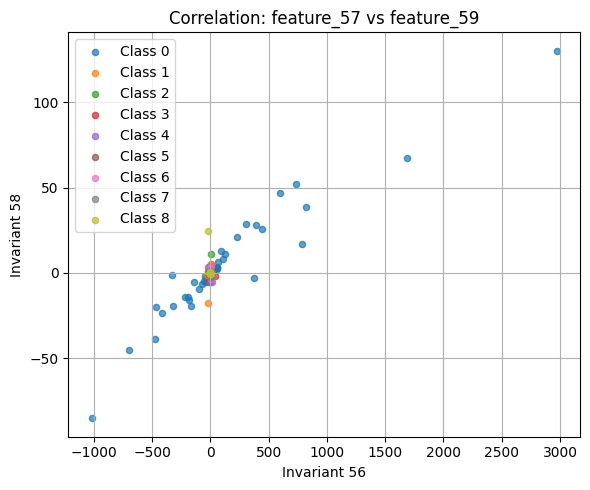

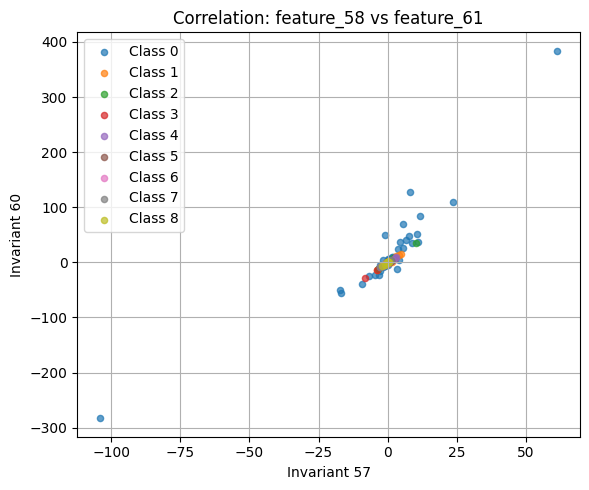

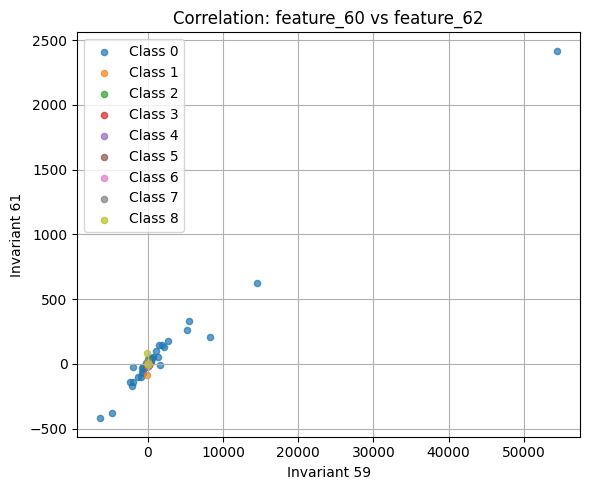

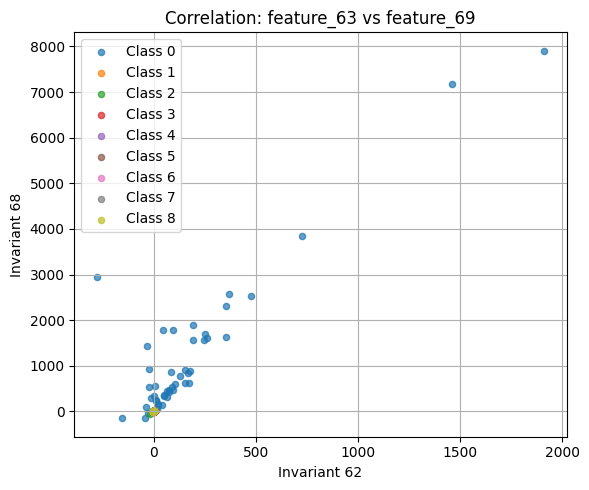

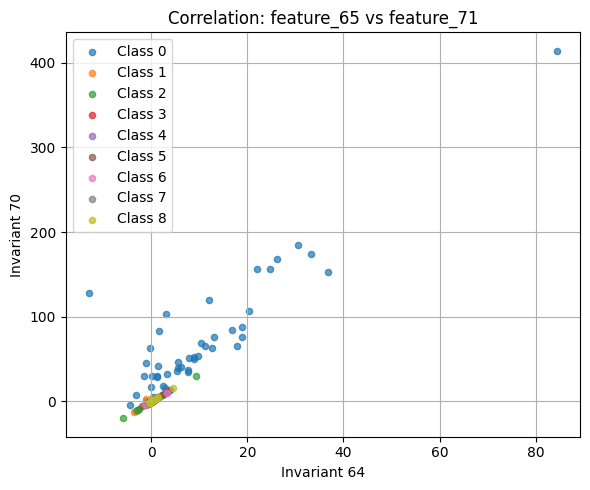

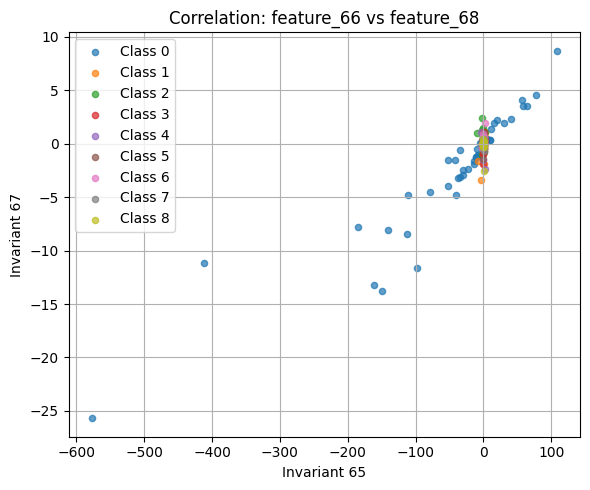

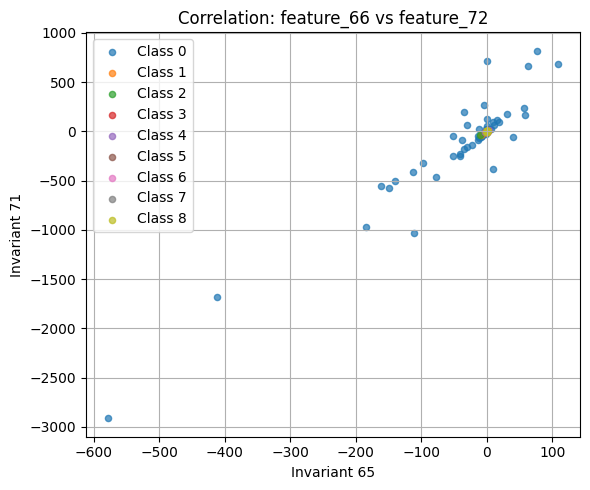

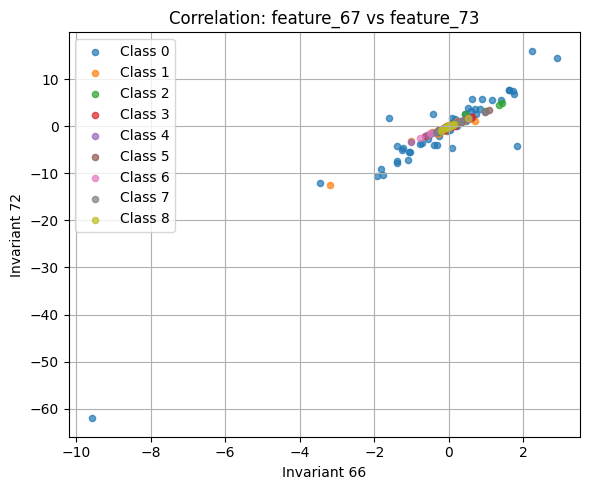

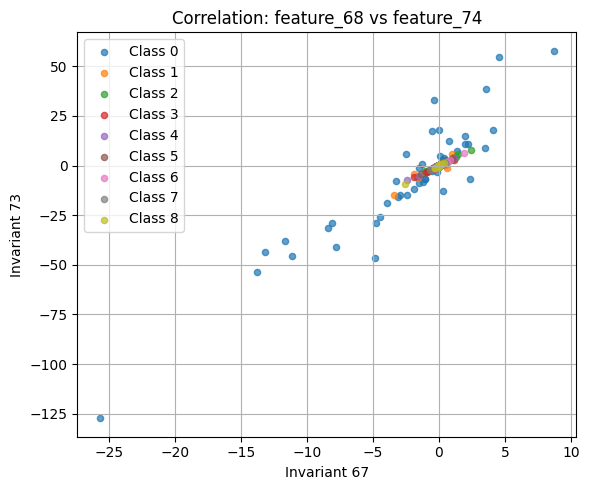

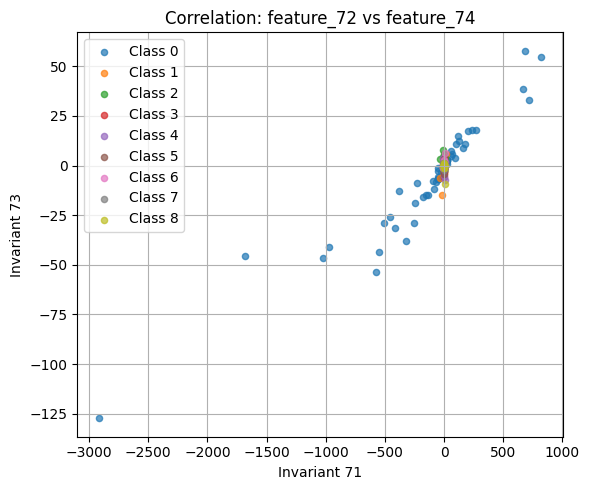

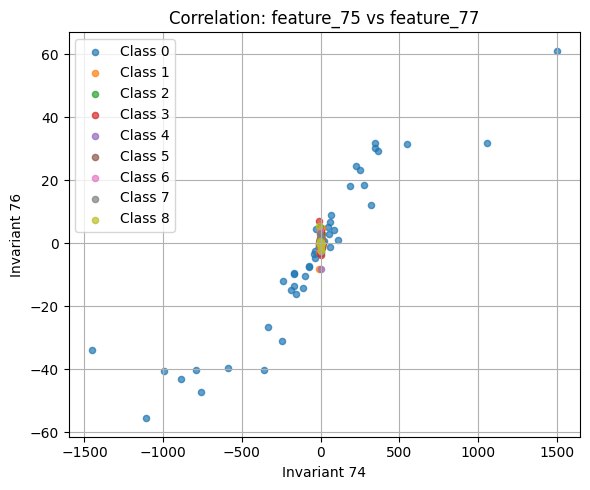

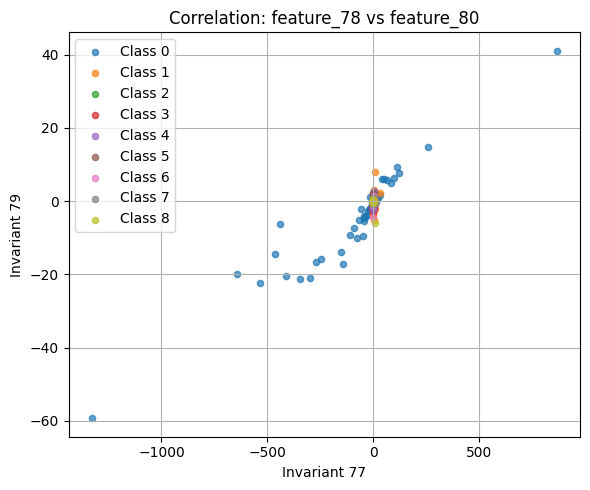

In [37]:
for pair in pairs_only:
    f1, f2 = pair
    i = feature_names.index(f1)
    j = feature_names.index(f2)
    plot_invariant_pair(X, labels, i, j, title=f"Correlation: {f1} vs {f2}")
    

In [38]:
feature_map = {
    1: "m000",
    2: "abs(m100)",
    6: "m200*m002^*",
    7: "m110",
    8: "m002^* * m100^2",
    9: "m200^* * m100^2",
    12: "abs(m300)",
    13: "abs(m003)",
    14: "m300*m003^*",
    15: "abs(m210)",
    16: "m300*m210^*^3",
    18: "m003*m210^*^3",
    20: "abs(m102)",
    22: "m300*m102^*",
    23: "m003*m102^*",
    24: "m102*m210^*^3",
    28: "abs(m012)",
    34: "m300*m012^*^3",
    35: "m003*m012^*^3",
    37: "m012*m210^*",
    39: "m102*m012^*^3",
    42: "(m300^2)*m200^*^3",
    44: "(m300^2)*m002^*^3",
    45: "(m003^2)*m200^*^3",
    46: "(m003^2)*m002^*^3",
    48: "m200*m210^*^2",
    50: "m002*m210^*^2",
    51: "(m102^2)*m200^*^3",
    52: "(m102^2)*m002^*^3",
    53: "m200*m012^*^2",
    54: "m002*m012^*^2",
    56: "m300*m100^*^3",
    57: "m003*m100^*^3",
    58: "m210*m100^*",
    59: "m102*m100^*^3",
    60: "m012*m100^*",
    61: "m100*m210*m200^*",
    62: "m100*m210*m002^*",
    63: "m100*m210*m012^*",
    64: "m100*m012*m002^*",
    65: "m012*m210*m200^*",
    67: "m012*m210*m002^*",
    68: "(m100^2)*m210*m300^*",
    69: "(m100^2)*m210*m003^*",
    70: "(m100^2)*m210*m102^*",
    71: "(m100^2)*m012*m300^*",
    73: "(m100^2)*m012*m003^*",
    74: "(m100^2)*m012*m102^*",
    78: "(m210^2)*m100*m300^*",
    80: "(m210^2)*m100*m003^*",
}
